In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from collections import defaultdict
from statistics import mean
from functools import reduce

Using TensorFlow backend.
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np

# Load DataSet

In [2]:
df_addr = "articles_by_year_number_of_authors_percentage_summery.pkl"

In [3]:
df = pd.read_pickle(df_addr)

In [4]:
df = df.apply(lambda x: x / 100)[:"2018"]

In [5]:
df

num_of_authors,1,2,3,4,5,6,7,8,9
year,,,,,,,,,
1936,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1937,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1938,0.900000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1939,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1940,0.800000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2014,0.101589,0.248187,0.272674,0.189458,0.098353,0.045894,0.019739,0.009830,0.005281
2015,0.098366,0.236847,0.268703,0.192924,0.105060,0.050884,0.021504,0.010617,0.005571
2016,0.090670,0.229360,0.265254,0.197680,0.111165,0.054291,0.023577,0.011704,0.006001


# Create Models

## LSTM

In [6]:
def create_data(df, train_test_sep):
    total_data = df.values
    print("total data: %s" % (total_data.shape,))

    train_data = total_data[:-train_test_sep]
    print("train data: %s" % (train_data.shape,))

    test_data = total_data[-train_test_sep:]
    print("test data: %s" % (test_data.shape,))
    
    return train_data, test_data

In [7]:
def create_lookback_dataset(dataset, n, look_back):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back):
        featrues = np.concatenate(list(map(lambda x: x[n:n+1], dataset[i:(i + look_back)])))
        y = i / 100
        featrues = np.concatenate(([y], featrues))
#         featrues = np.concatenate(([y], featrues, featrues * y))
        data_x.append(featrues)
        data_y.append(dataset[i + look_back][n])
    return np.array(data_x), np.array(data_y)

In [8]:
def prepare_data(data, time_steps, n):
    X, y = create_lookback_dataset(data, n - 1, time_steps)
    X = X.reshape((X.shape[0], len(X[0]), 1))
    print("X: %s,\ty: %s" % (X.shape, y.shape))
    return X, y

In [9]:
def train_model(X_train, y_train):
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 100))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)
    
    return model, history

In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    print("last train loss: %s,\tlast test loss: %s" % (history.history['loss'][-1], history.history['val_loss'][-1]))

In [44]:
def plot_test_data_aggr(model, n, X_test, y_test):
    time_axis = np.arange(2019 - len(y_test), 2019)
#     print(time_axis)
    plt.plot(list(range(len(time_axis))), y_test * 100, label = 'Real (%d author(s))' % n)
    plt.plot(list(range(len(time_axis))), model.predict(X_test) * 100, label = 'Predicted (%d author(s))' % n)
    plt.xticks(list(range(len(time_axis))), time_axis, rotation=45)

In [11]:
def plot_train_data(model, n, X_train, y_train, y_test, time_steps):
    time_axis = np.arange(2019 - len(y_test) - len(y_train) - time_steps, 2019 - len(y_test) - time_steps)
#     print(time_axis)
    plt.figure(figsize = (15,6))
    plt.plot(list(range(len(time_axis))), y_train * 100, color = 'red', label = 'Real')
    plt.plot(list(range(len(time_axis))), model.predict(X_train) * 100, color = 'blue', label = 'Predicted')
    plt.xticks(list(range(len(time_axis))), time_axis, rotation=45)
    plt.title("Prediction over Train Data\nn = %s" % n)
    plt.xlabel('year')
    plt.ylabel('%% of articles with %s author(s)' % n)
    plt.legend()
    plt.show()

In [12]:
def plot_test_data(model, n, X_test, y_test):
    time_axis = np.arange(2019 - len(y_test), 2019)
#     print(time_axis)
    plt.figure(figsize = (15,6))
    plt.plot(list(range(len(time_axis))), y_test * 100, color = 'red', label = 'Real')
    plt.plot(list(range(len(time_axis))), model.predict(X_test) * 100, color = 'blue', label = 'Predicted')
    plt.xticks(list(range(len(time_axis))), time_axis, rotation=45)
    plt.title("Prediction over Test Data\nn = %s" % n)
    plt.xlabel('year')
    plt.ylabel('%% of articles with %s author(s)' % n)
    plt.legend()
    plt.show()

In [13]:
def plot_train_test_data(model, n, X_train, y_train, X_test, y_test, time_steps):
    time_axis = np.concatenate((
        np.arange(2019 - len(y_test) - len(y_train) - time_steps, 2019 - len(y_test) - time_steps),
        np.arange(2019 - len(y_test), 2019)
    ))
#     print(time_axis)
    plt.figure(figsize = (25,6))
    plt.plot(list(range(len(time_axis))), np.concatenate((y_train, y_test)) * 100, color = 'red', label = 'Real')
    plt.plot(
        list(range(len(time_axis))),
        np.concatenate((model.predict(X_train).reshape(-1, 1), model.predict(X_test).reshape(-1, 1))) * 100,
        color = 'blue',
        label = 'Predicted'
    )
    plt.xticks(list(range(len(time_axis))), time_axis, rotation=45)
    plt.title("Prediction over Train & Test Data\nn = %s" % n)
    plt.xlabel('year')
    plt.ylabel('%% of articles with %s author(s)' % n)
    plt.legend()
    plt.show()

In [14]:
def get_err(y_pred, y_test):
    return mean(np.square(y_pred - y_test))

In [45]:
def predict_one(train_data, test_data, time_steps, n):
    print("n = %s" % n)
    print("Train Data")
    X_train, y_train = prepare_data(train_data, time_steps, n)
    print("Test Data")
    X_test, y_test = prepare_data(test_data, time_steps, n)
    
    model, history = train_model(X_train, y_train)
    plot_loss(history)
    
    y_pred = model.predict(X_test)
    
#     plot_test_data_aggr(model, n, X_test, y_test)
    plot_train_data(model, n, X_train, y_train, y_test, time_steps)
    plot_test_data(model, n, X_test, y_test)
    plot_train_test_data(model, n, X_train, y_train, X_test, y_test, time_steps)
    
    y_pred = y_pred.reshape(-1)
    err = get_err(y_pred, y_test)
    print("AVG MSE Err: %s" % err)
    
    print()
    
    return err
    

In [43]:
def predict(df, train_test_sep, time_steps):
    train_data, test_data = create_data(df, train_test_sep)
    print()
#     plt.figure(figsize = (15,6))
    errs = [predict_one(train_data, test_data, time_steps, i + 1) for i in range(5)]
    print()
    print("AVG Total MSE Err: %s" % mean(errs))
#     plt.xlabel('year')
#     plt.ylabel('%% of articles')
#     plt.legend()
#     plt.show()
    return mean(errs)

total data: (83, 9)
train data: (58, 9)
test data: (25, 9)

n = 1
Train Data
X: (48, 11, 1),	y: (48,)
Test Data
X: (15, 11, 1),	y: (15,)
Train on 33 samples, validate on 15 samples
Epoch 1/20
33/33 [==============================] - 2s 56ms/step - loss: 0.3466 - val_loss: 0.0049
Epoch 2/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0374 - val_loss: 0.0969
Epoch 3/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0394 - val_loss: 0.0088
Epoch 4/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0020
Epoch 5/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0024
Epoch 6/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0191
Epoch 7/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0309
Epoch 8/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 0.0137
Epoch 9/20
33/33 [================

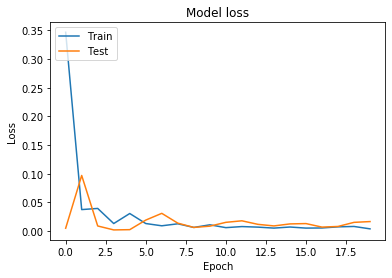

last train loss: 0.0037962401313989453,	last test loss: 0.01650071268280347


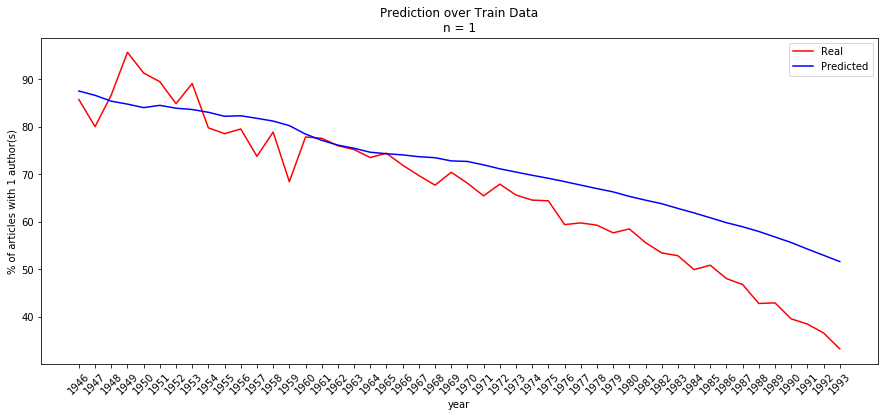

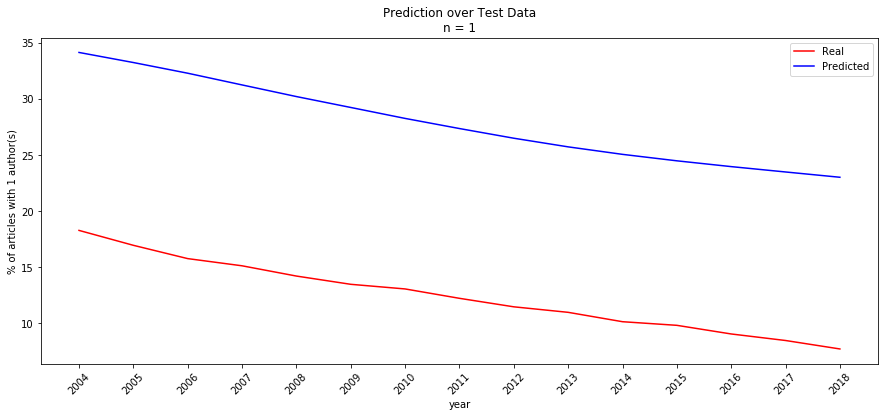

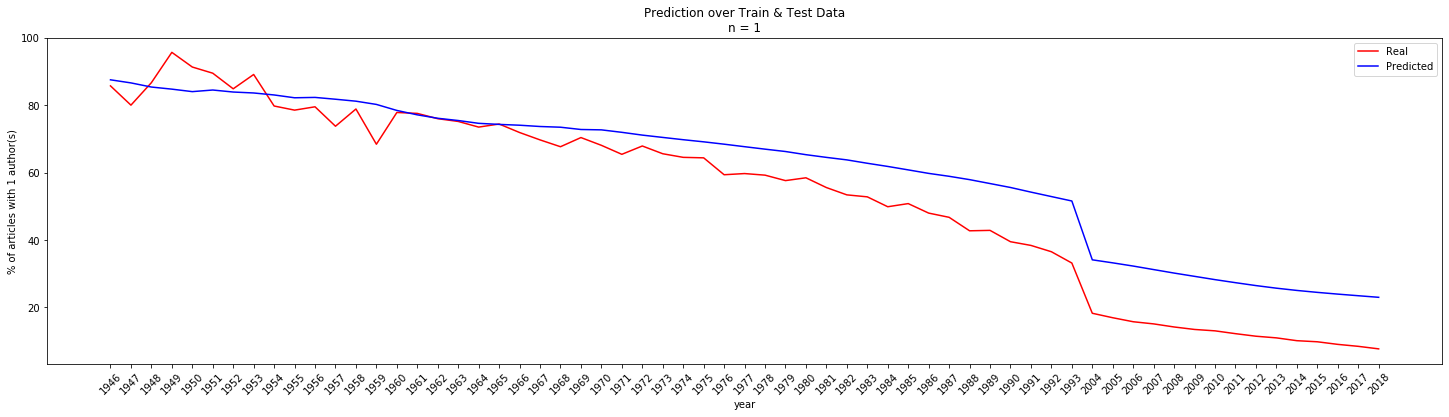

AVG MSE Err: 0.023805682989594006

n = 2
Train Data
X: (48, 11, 1),	y: (48,)
Test Data
X: (15, 11, 1),	y: (15,)
Train on 33 samples, validate on 15 samples
Epoch 1/20
33/33 [==============================] - 2s 58ms/step - loss: 0.0263 - val_loss: 0.0070
Epoch 2/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 4.1721e-04
Epoch 3/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0061
Epoch 4/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0083
Epoch 5/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 2.1577e-04
Epoch 7/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 8/20
33/33 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 9/20
33/33 [==============================] -

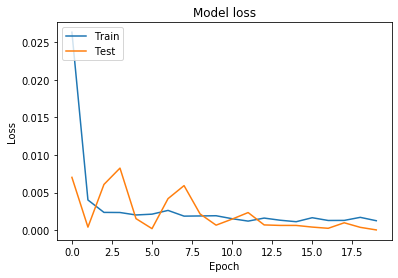

last train loss: 0.0012679962991652164,	last test loss: 4.6708513157985486e-05


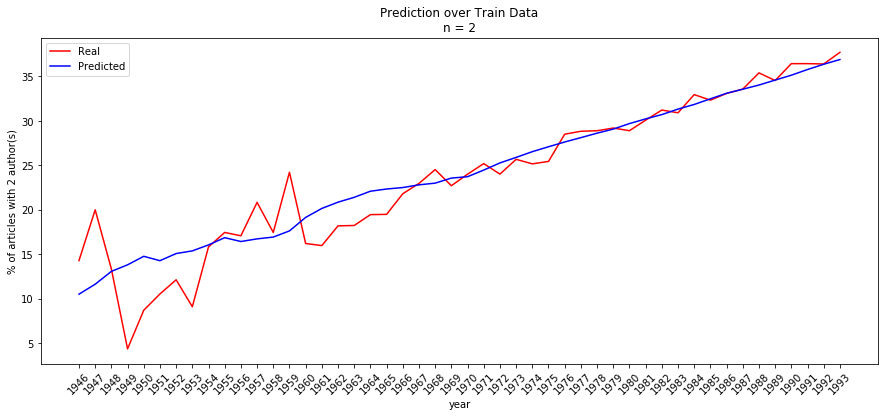

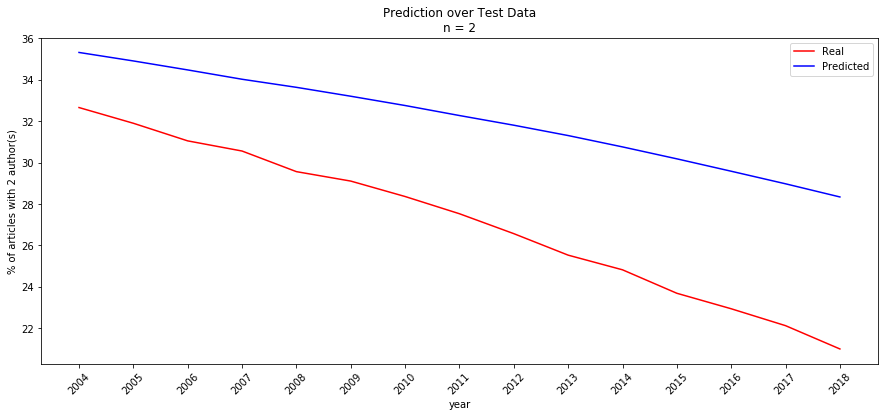

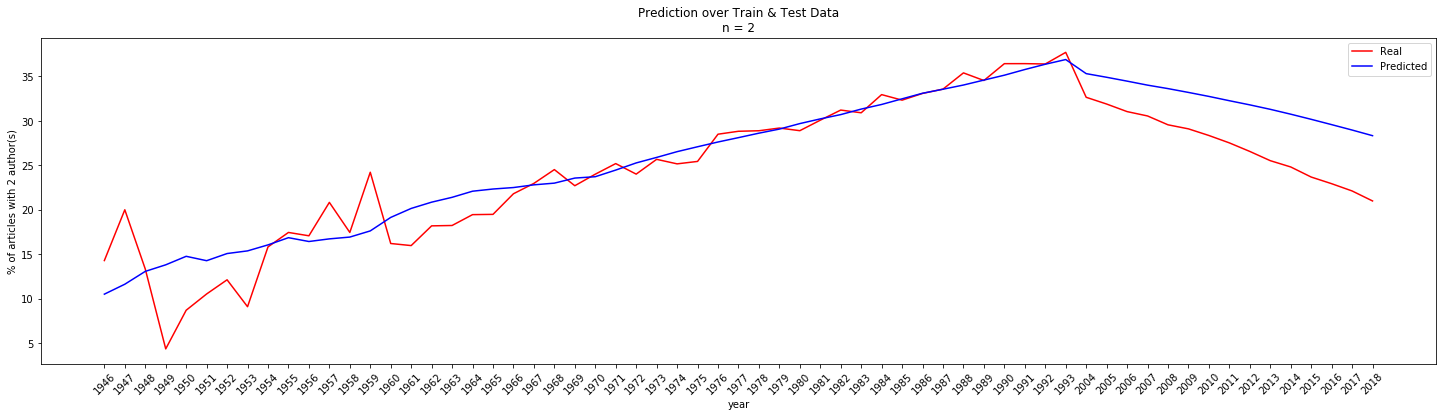

AVG MSE Err: 0.0026576869664119004

n = 3
Train Data
X: (48, 11, 1),	y: (48,)
Test Data
X: (15, 11, 1),	y: (15,)
Train on 33 samples, validate on 15 samples
Epoch 1/20
33/33 [==============================] - 2s 61ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 2/20
33/33 [==============================] - 0s 1ms/step - loss: 4.7011e-04 - val_loss: 0.0052
Epoch 3/20
33/33 [==============================] - 0s 1ms/step - loss: 4.5241e-04 - val_loss: 0.0047
Epoch 4/20
33/33 [==============================] - 0s 1ms/step - loss: 3.2181e-04 - val_loss: 0.0013
Epoch 5/20
33/33 [==============================] - 0s 1ms/step - loss: 2.2820e-04 - val_loss: 0.0013
Epoch 6/20
33/33 [==============================] - 0s 1ms/step - loss: 1.0532e-04 - val_loss: 0.0013
Epoch 7/20
33/33 [==============================] - 0s 1ms/step - loss: 1.2344e-04 - val_loss: 4.0238e-04
Epoch 8/20
33/33 [==============================] - 0s 1ms/step - loss: 1.1643e-04 - val_loss: 1.7186e-04
Epoch 9/20
33/33 [====

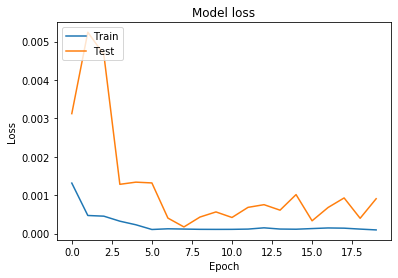

last train loss: 9.413808165294485e-05,	last test loss: 0.000906841674198707


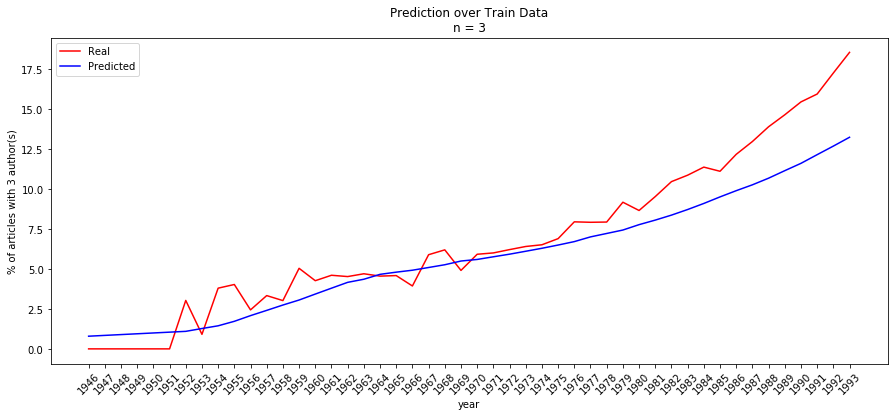

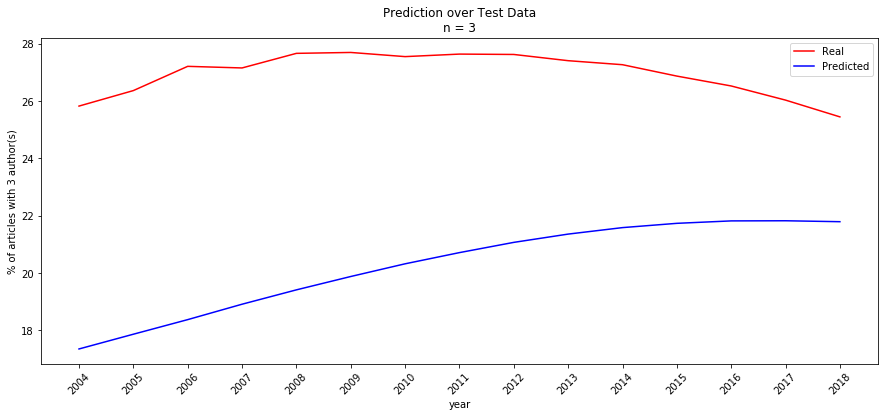

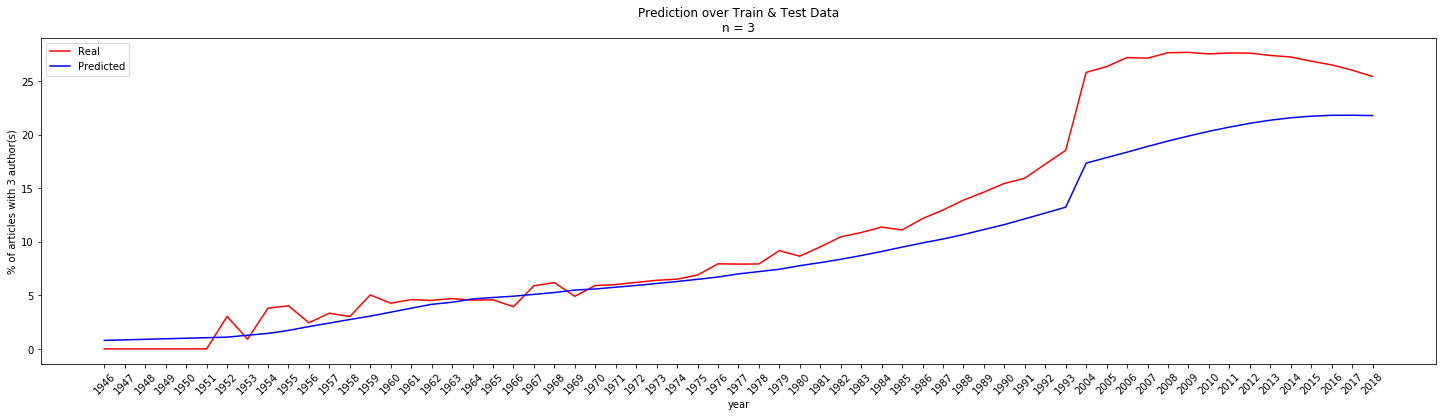

AVG MSE Err: 0.004740593776083579

n = 4
Train Data
X: (48, 11, 1),	y: (48,)
Test Data
X: (15, 11, 1),	y: (15,)
Train on 33 samples, validate on 15 samples
Epoch 1/20
33/33 [==============================] - 2s 64ms/step - loss: 1.7450e-04 - val_loss: 0.0012
Epoch 2/20
33/33 [==============================] - 0s 1ms/step - loss: 1.1350e-04 - val_loss: 6.8611e-04
Epoch 3/20
33/33 [==============================] - 0s 1ms/step - loss: 6.8824e-05 - val_loss: 3.7452e-04
Epoch 4/20
33/33 [==============================] - 0s 1ms/step - loss: 5.6477e-05 - val_loss: 7.6611e-04
Epoch 5/20
33/33 [==============================] - 0s 1ms/step - loss: 3.7273e-05 - val_loss: 3.0507e-04
Epoch 6/20
33/33 [==============================] - 0s 1ms/step - loss: 3.6551e-05 - val_loss: 2.5897e-04
Epoch 7/20
33/33 [==============================] - 0s 1ms/step - loss: 2.9473e-05 - val_loss: 4.5030e-04
Epoch 8/20
33/33 [==============================] - 0s 1ms/step - loss: 3.2579e-05 - val_loss: 2.2285e-04

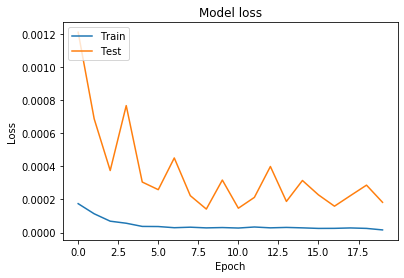

last train loss: 1.61610631342531e-05,	last test loss: 0.0001825775543693453


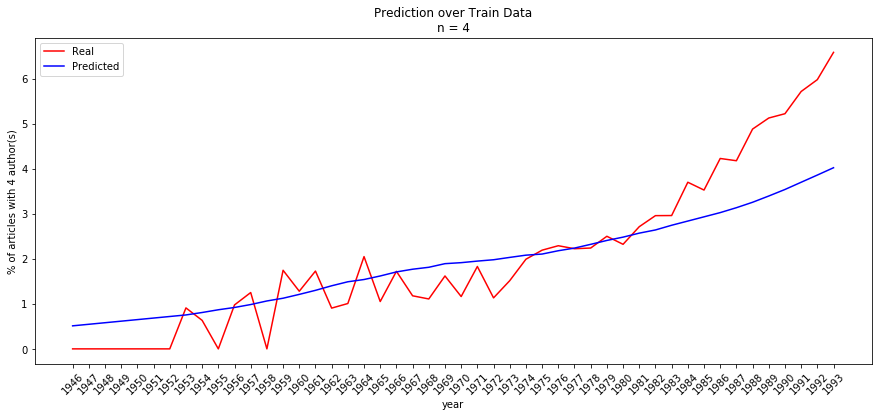

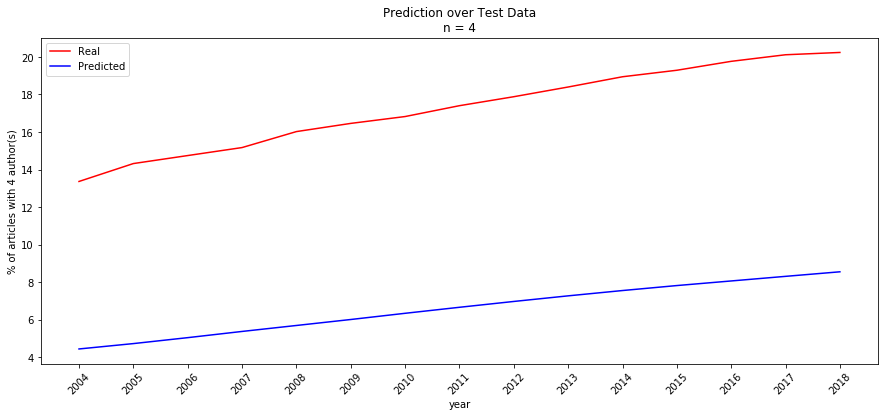

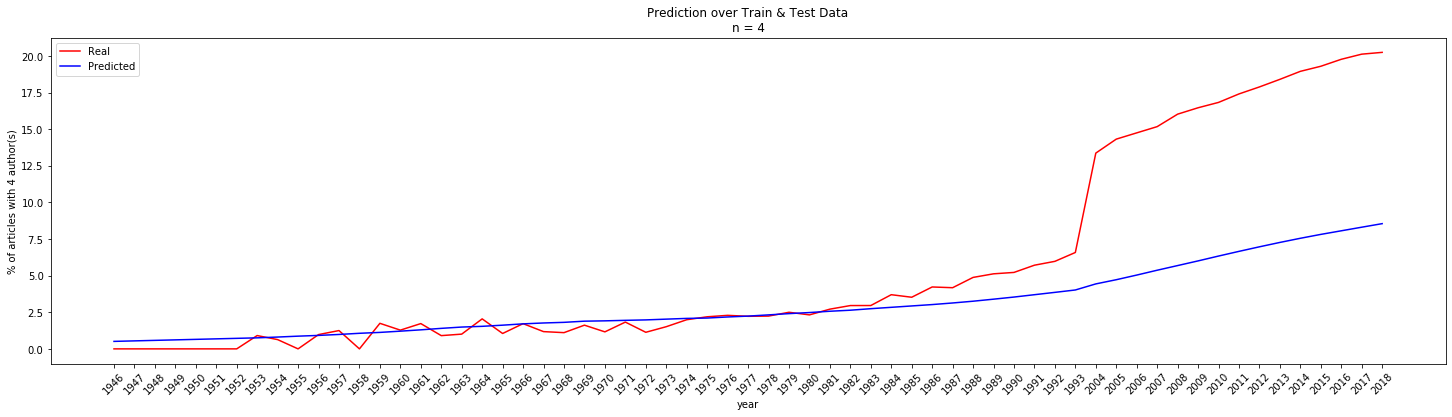

AVG MSE Err: 0.011478950860597187

n = 5
Train Data
X: (48, 11, 1),	y: (48,)
Test Data
X: (15, 11, 1),	y: (15,)


In [ ]:
train_test_sep = 25
time_steps = 10

overall_err = predict(df, train_test_sep, time_steps)

In [18]:
overall_err

0.009529751315330081

In [19]:
# train_test_sep = 25
# err = dict()
# for n in [1, 5, 7, 10, 12, 15, 20]:
#     err[n] = predict(df, train_test_sep, n)
# print()
# print("-" * 30)
# for n in [1, 5, 7, 10, 12, 15, 20]:
#     print("n = %s, err = %s" % (n, err[n]))

## SVR

In [20]:
def get_data(df, n, window_size):
    n -= 1
    features = dict()
    res = dict()
    for year in range(1936 + window_size, 2019):
        feature = list()
        for feature_year in range(window_size, 0, -1):
            feature += list(df.loc[str(year - feature_year)].values)[n:n+1]
        feature += list(np.array(feature) * ((year - 1936) / 100))
        feature += [((year - 1936) / 100)]
        features[year] = feature
        res[year] = list(df.loc[str(year)])
    return features, res

In [21]:
def get_err(y_pred, y_test):
    return mean(np.square(y_pred - y_test))

In [22]:
def predict_one_svr(df, n, time_steps, test_num):
    print("n = %s" % n)
    
    features, res = get_data(df, n, time_steps)
        
    X = list(features.values())[:-test_num]
    print(len(X[0]))
    y = list(map(lambda l: l[n], list(res.values())))[:-test_num]

    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=1e3, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=1e3, gamma=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, gamma=1e3, degree=3, epsilon=.1, coef0=1)
    
    errs = []

    lw = 2

    svrs = [svr_rbf, svr_lin, svr_poly]
    kernel_label = ['RBF', 'Linear', 'Polynomial']
    model_color = ['m', 'c', 'g']

    time_axis = np.arange(2019 - test_num, 2019)
#     time_axis = np.arange(1936 + time_steps, 2019)
    # time_axis = np.arange(1936 + time_steps, 2019 - test_num)

    fig, axes = plt.subplots(nrows=len(svrs), ncols=1, figsize=(15, 5 * len(svrs)), sharey=True)
    for ix, svr in enumerate(svrs):
        print("kernel: %s" % kernel_label[ix])
        y_pred = svr.fit(X, y).predict(list(features.values())[-test_num:])
        y_test = np.array(list(map(lambda l: l[n], list(res.values()))))[-test_num:]
        err = get_err(y_pred, y_test)
        errs.append(err)
        print("MSE Err: %s" % err)

        axes[ix].plot(time_axis, y_test * 100, color='k', lw=lw, label='expected')
        axes[ix].plot(time_axis, y_pred * 100, color=model_color[(ix) % len(model_color)], lw=lw, label='{} model'.format(kernel_label[ix]))
#         axes[ix].plot(time_axis, (y_pred - y_test) * 100, color=model_color[(ix+2) % len(model_color)], lw=lw, label='diff')
        axes[ix].legend()
    
    plt.show()
    print()
    return tuple(errs)

In [23]:
def predict_svr(df, time_steps, train_test_sep):
    errs_rbf, errs_lin, errs_poly = [], [], []
    
    for n in range(5):
        err_rbf, err_lin, err_poly = predict_one_svr(df, n + 1, time_steps, train_test_sep)
        errs_rbf.append(err_rbf)
        errs_lin.append(err_lin)
        errs_poly.append(err_poly)
    
    print("AVG MSE Err %s: %s" % ("RBF", mean(errs_rbf)))
    print("AVG MSE Err %s: %s" % ("Lin", mean(errs_lin)))
    print("AVG MSE Err %s: %s" % ("Poly", mean(errs_poly)))
    return mean(errs_rbf), mean(errs_lin), mean(errs_poly) 

n = 1
41
kernel: RBF
MSE Err: 0.004191411686175462
kernel: Linear
MSE Err: 0.003497722122378999
kernel: Polynomial
MSE Err: 0.0033906423927289576


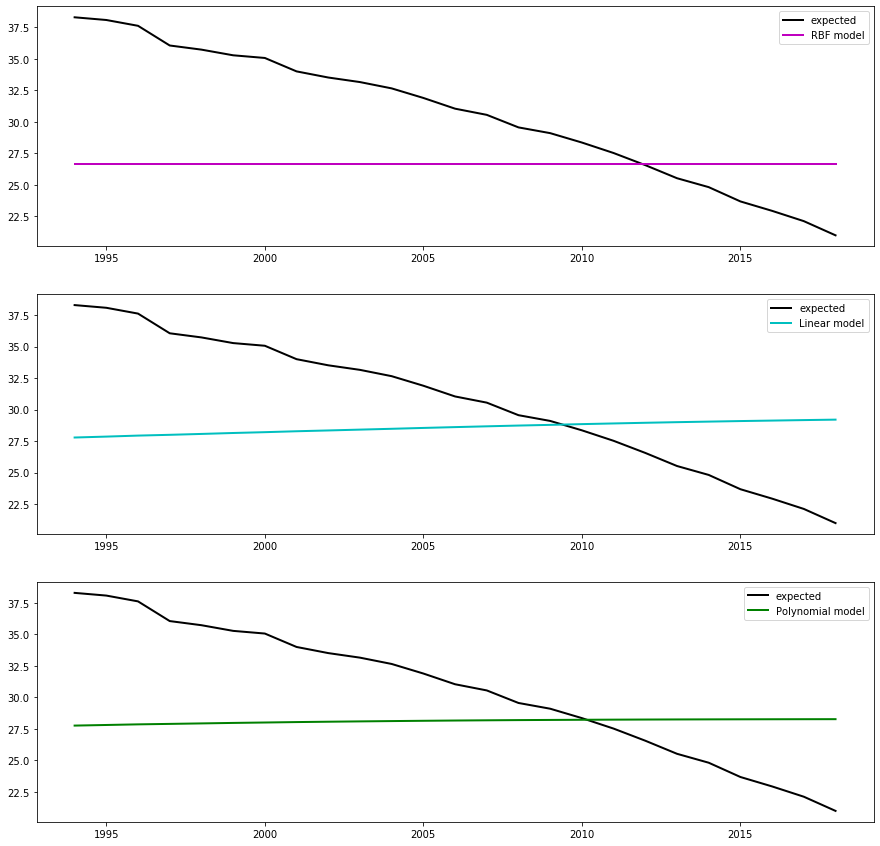


n = 2
41
kernel: RBF
MSE Err: 0.021912866706355758
kernel: Linear
MSE Err: 0.021912866706355758
kernel: Polynomial
MSE Err: 0.021912866706355758


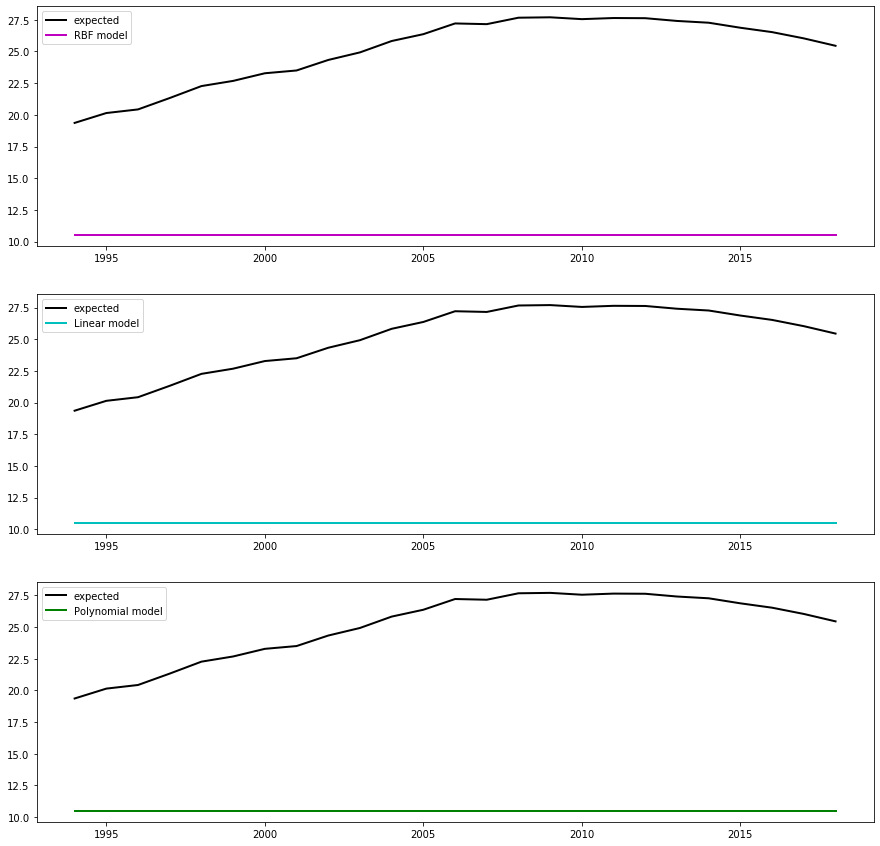


n = 3
41
kernel: RBF
MSE Err: 0.01364576354775579
kernel: Linear
MSE Err: 0.01364576354775579
kernel: Polynomial
MSE Err: 0.01364576354775579


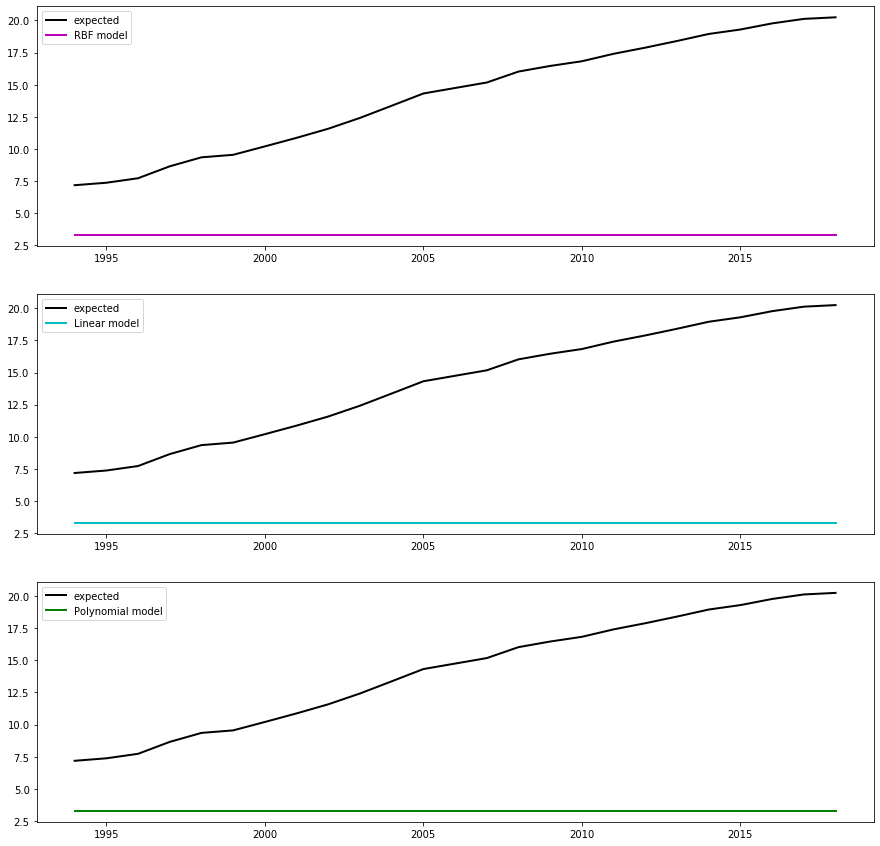


n = 4
41
kernel: RBF
MSE Err: 0.0038376259730649818
kernel: Linear
MSE Err: 0.0038376259730649818
kernel: Polynomial
MSE Err: 0.0038376259730649818


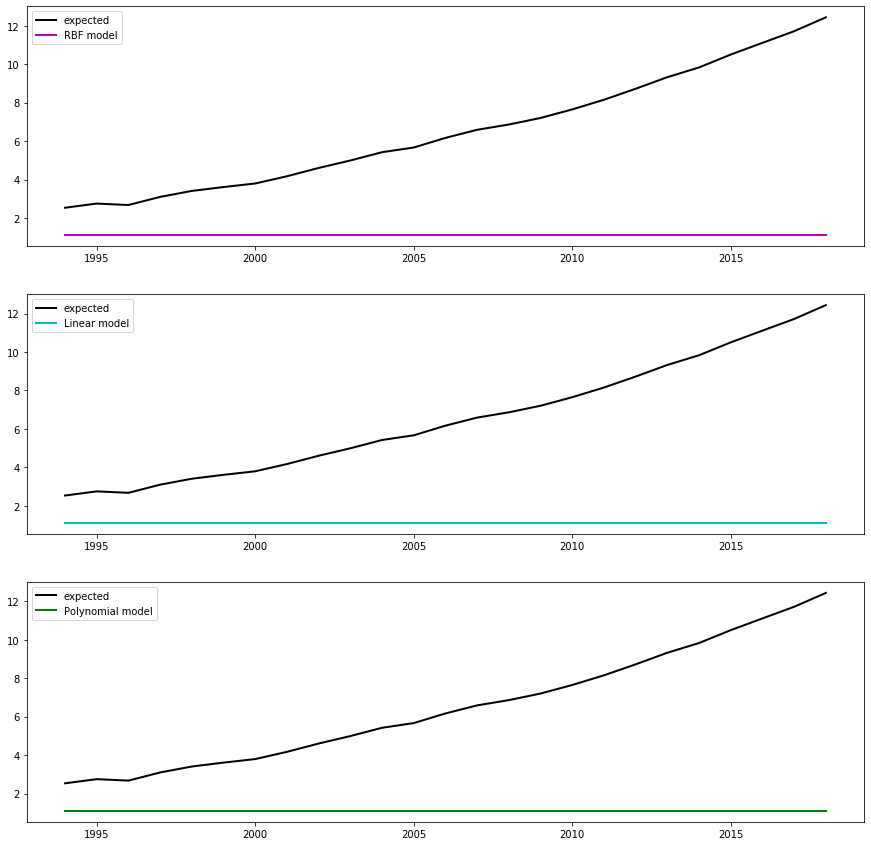


n = 5
41
kernel: RBF
MSE Err: 0.0008690006249123635
kernel: Linear
MSE Err: 0.0008690006249123635
kernel: Polynomial
MSE Err: 0.0008690006249123635


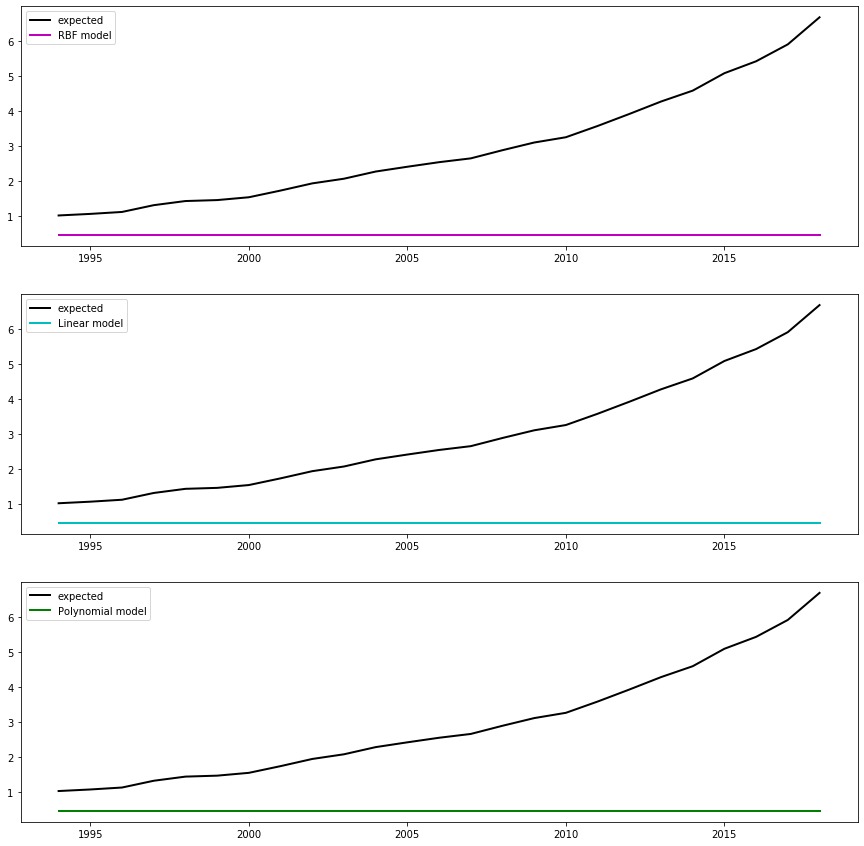


AVG MSE Err RBF: 0.008891333707652872
AVG MSE Err Lin: 0.008752595794893578
AVG MSE Err Poly: 0.00873117984896357


In [24]:
train_test_sep = 25
time_steps = 20
errs_rbf, errs_lin, errs_poly = predict_svr(df, time_steps, train_test_sep)

In [25]:
print(errs_rbf, errs_lin, errs_poly)

0.008891333707652872 0.008752595794893578 0.00873117984896357


In [26]:
# train_test_sep = 25
# errs_rbf = dict()
# errs_lin = dict()
# errs_poly = dict()
# for n in [1, 5, 7, 10, 12, 15, 20]:
#     errs_rbf[n], errs_lin[n], errs_poly[n] = predict_svr(df, n, train_test_sep)
# print()
# print("-" * 30)
# for n in [1, 5, 7, 10, 12, 15, 20]:
#     print("n = %s, err_rbf = %s, err_lin = %s, err_poly = %s" % (n, errs_rbf[n], errs_lin[n], errs_poly[n]))

## Year-based SVR

In [27]:
n = 1
prices = df[n]["1980":"2009"].values * 100
# dates = df.index.values
dates = np.arange(1980, 2010) - 2000

dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))
print(len(dates), len(prices))

new_prices = df[n]["2010":].values * 100
new_dates = np.arange(2010, 2019) - 2000

new_dates = np.reshape(new_dates, (len(new_dates), 1))
new_prices = np.reshape(new_prices, (len(new_prices), 1))
print(len(new_dates), len(new_prices))

30 30
9 9


In [28]:
svr_rbf_orig = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf_orig.fit(dates, prices)

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 1e100)
# svr_rbf = SVR(kernel='linear', C=100, gamma='auto')
# svr_rbf = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
svr_rbf.fit(dates, prices)

/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hadi/Codes/data/dblp-collaboration-trends/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e+100,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

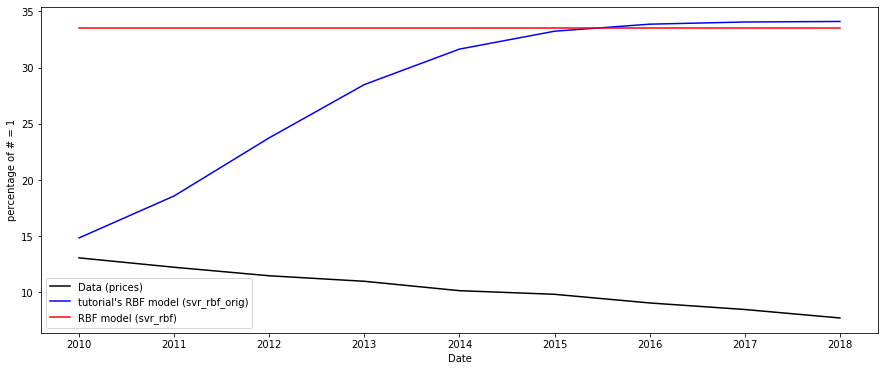

In [29]:
plt.figure(figsize = (15,6))
plt.plot(new_dates + 2000, new_prices, color= 'black', label= 'Data (prices)')
plt.plot(new_dates + 2000, svr_rbf_orig.predict(new_dates), color= 'blue', label= 'tutorial\'s RBF model (svr_rbf_orig)') 
plt.plot(new_dates + 2000, svr_rbf.predict(new_dates), color= 'red', label= 'RBF model (svr_rbf)') 
plt.xlabel('Date')
plt.ylabel('percentage of # = %d' % n)
plt.legend()
plt.show()
# np.concatenate(dates, new_dates)

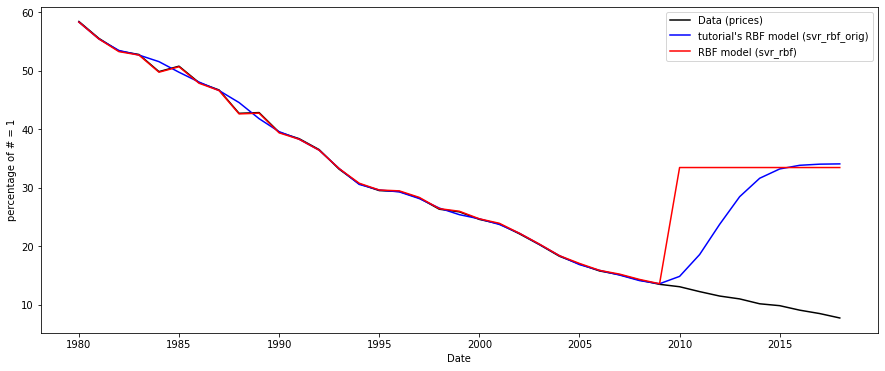

In [30]:
plt.figure(figsize = (15,6))
plt.plot(np.concatenate((dates, new_dates)) + 2000, np.concatenate((prices, new_prices)), color= 'black', label= 'Data (prices)')
plt.plot(np.concatenate((dates, new_dates)) + 2000, np.concatenate((svr_rbf_orig.predict(dates), svr_rbf_orig.predict(new_dates))), color= 'blue', label= 'tutorial\'s RBF model (svr_rbf_orig)') 
plt.plot(np.concatenate((dates, new_dates)) + 2000, np.concatenate((svr_rbf.predict(dates), svr_rbf.predict(new_dates))), color= 'red', label= 'RBF model (svr_rbf)') 
plt.xlabel('Date')
plt.ylabel('percentage of # = %d' % n)
plt.legend()
plt.show()
# np.concatenate(dates, new_dates)